# Topic modeling 
Objective : identify topics emerging from comments

##  Required packages

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import itertools

import re
import emoji

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

import spacy

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline

from time import time
from sklearn import metrics

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB, GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


## Load data

In [4]:
# load the data
data = pd.read_csv("redoute_v3.csv")

# Now we are interested only on comments and ratings
df = data[["comment", "rating"]]

# check nan values
print(df.isna().sum())

print(df.info())

comment    0
rating     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23469 entries, 0 to 23468
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  23469 non-null  object
 1   rating   23469 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 366.8+ KB
None


## Prepare the data - Text processing
The objective is to clean the comments text, that is:
- remove special characters
- remove numbers
- remove punctuations
- remove stop words (word with no meaningful information e.g. 'le', 'la', 'les' etc.French stops woard sinces we are dealing with customers reviews in french.
- lemmatize words (text pre-processing technique that reduces a word to its <b>root meaning</b> to identify similarities)
- stemming (In linguistic morphology and information retrieval, stemming is the process of reducing inflected words to their <b>word stem, base or root form</b>—generally a written word form. cf. Wikipedia)

### Clean the dataset

In [5]:
# Define stop words
stopwords_to_add = ["être", "leur", "leurs", "avoir", "cela", "les", "de", "pour", "des", "cette", "a",
                   "j'ai", "car", "c'est", "chez", "tout", "fait", "chez", "donc", 
                   "n'est", "si", "alors", "n'ai", "faire", "deux", "comme", "jour", "tr", "si", "ue"]

stop_words = set(stopwords.words('french'))  | set(stopwords_to_add)

In [6]:
# Function to clean comments text
# cf. https://github.com/priya-dwivedi/Deep-Learning/tree/master/text_classification_with_BERT
def clean_dataset(text):
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove tickers
    text = re.sub(r'\$\w*', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)
    # Remove URL, RT, mention(@)
    text=  re.sub(r'http(\S)+', '',text)
    text=  re.sub(r'http ...', '',text)
    text=  re.sub(r'(RT|rt)[ ]*@[ ]*[\S]+','',text)
    text=  re.sub(r'RT[ ]?@','',text)
    text = re.sub(r'@[\S]+','',text)
    # Remove words with 3 or fewer letters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)
    #&, < and >
    text = re.sub(r'&amp;?', 'and',text)
    text = re.sub(r'&lt;','<',text)
    text = re.sub(r'&gt;','>',text)
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove emoji
    text = emoji.demojize(text)
    #1. Remove Puncs
    # \w typically matches [A-Za-z0-9_]
    text = re.sub('[^\w\s]',' ', text)
    #2. Tokenize
    text_tokens = word_tokenize(text.lower(), language='french') 
    #3. Remove numbers
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    #4. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    #joining
    text =  " ".join(tokens_without_sw)
    return text

In [7]:
# Clean the comments 
df["comment_cleaned"] = df["comment"].apply(clean_dataset)

In [8]:
#contrôle
w = df["comment"]
z = df["comment_cleaned"]
for i in range(5):
    print(str(i)+"*** --------------")
    print(z[i])
    print("--original text-----")
    print(w[i])

0*** --------------
facilte sollicitations dosées qualité pourrait cependant améliorer volet recap commandes appli moment livraison lorsque propres équipes intervenants autres communiquent rappel systématique contenu commande numéro redoute sociétés livraison code bien quand commande beaucoup modes livraison différents manière rythmes sportif ailleurs bien sociétés livraison quand elles livrent alignent look mails autres type communication vôtre service parfait bout bout concernant marques autres vôtres distribuez chargent livrer annoncez parfois dates livraison correspondent général livré avant certes achetons vois devriez informés elles vraies dates livraison redoute reste transparent
--original text-----
Facilte, sollicitations dosées...qualité..on pourrait cependant améliorer le volet recap commandes sur l'appli avec au moment de la livraison, lorsque vos propres équipes ou des intervenants autres communiquent avec nous un rappel systématique du contenu de la commande et son numéro

### Lemmatize 

In [9]:
# Lemmatization with SPACY
nlp = spacy.load('fr_core_news_md')

def lemmatize_text(text):
    tokens = nlp(text)  
    text_lemmatized = ""
    for token in tokens:
        text_lemmatized =  text_lemmatized + token.lemma_ + " "
    return text_lemmatized


In [10]:
# Lemmatize text of comment cleaned
df["comment_lemmatized"] = df["comment_cleaned"].apply(lemmatize_text)

In [11]:
#contrôle
o = df["comment"]
w = df["comment_cleaned"]
z = df["comment_lemmatized"]

for i in range(5):
    print(str(i)+"lemm --------------")
    print(z[i])
    print("--cleaned text-----")
    print(w[i])
    print("--original text-----")
    print(o[i])

0lemm --------------
facilte sollicitation doser qualité pouvoir cependant améliorer volet recap commande appli moment livraison lorsque propre équipe intervenant autre communiquer rappel systématique contenu commande numéro redoute société livraison code bien quand commande beaucoup mode livraison différent manière rythme sportif ailleurs bien société livraison quand lui livrer aligner look mail autre type communication vôtre service parfait bout bout concerner marque autre vôtre distribuer charger livrer annoncer parfois date livraison correspondre général livrer avant certes acheter voir devoir informer lui vrai date livraison redoute reste transparent 
--cleaned text-----
facilte sollicitations dosées qualité pourrait cependant améliorer volet recap commandes appli moment livraison lorsque propres équipes intervenants autres communiquent rappel systématique contenu commande numéro redoute sociétés livraison code bien quand commande beaucoup modes livraison différents manière rythme

### Stemming

In [12]:
# function to to apply stemming
stemmer = SnowballStemmer(language='french')
def return_stem(texte):
    doc = nlp(texte)
    return' '.join([stemmer.stem(word.text) for word in doc])

In [13]:
# contrôle
text="facilte sollicitation doser qualité pouvoir cependant améliorer volet recap commande appli moment livraison lorsque propre équipe intervenant autre communiquer rappel systématique"

return_stem(text)

'facilt sollicit dos qualit pouvoir cepend amélior volet recap command appli moment livraison lorsqu propr équip interven autr communiqu rappel systémat'

In [14]:
# Apply stemming to comments lemmatized
df["comment_stem"] = df["comment_lemmatized"].apply(return_stem)

In [15]:
#contrôle
o = df["comment"]
w = df["comment_lemmatized"]
z = df["comment_stem"]

for i in range(5):
    print(str(i)+"-- stemm --------------")
    print(z[i])
    print("-- lemm -----")
    print(w[i])
   # print("-- original text ----")
    #print(o[i])

0-- stemm --------------
facilt sollicit dos qualit pouvoir cepend amélior volet recap command appli moment livraison lorsqu propr équip interven autr communiqu rappel systémat contenu command numéro redout societ livraison cod bien quand command beaucoup mod livraison différent mani rythm sportif ailleur bien societ livraison quand lui livr align look mail autr typ commun vôtr servic parf bout bout concern marqu autr vôtr distribu charg livr annonc parfois dat livraison correspondr général livr avant cert achet voir devoir inform lui vrai dat livraison redout rest transparent
-- lemm -----
facilte sollicitation doser qualité pouvoir cependant améliorer volet recap commande appli moment livraison lorsque propre équipe intervenant autre communiquer rappel systématique contenu commande numéro redoute société livraison code bien quand commande beaucoup mode livraison différent manière rythme sportif ailleurs bien société livraison quand lui livrer aligner look mail autre type communicatio

### CloudWords

In [16]:
from wordcloud import WordCloud
from PIL import Image

def plot_word_cloud(text, title, background_color = "white"):
    # Définir un masque
    # mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=500, 
                   stopwords=stop_words,  
                   max_font_size=90, random_state=42)
    # Générer et afficher le nuage de mots
    #plt.figure(figsize= (8,6))
    wc.generate(text)
    plt.title(title)
    plt.imshow(wc)
    plt.show()

def generate_word_cloud(text, background_color = "white"):
    # Définir un masque
    # mask_coloring = np.array(Image.open(str(masque)))
    # Définir le calque du nuage des mots
    wc = WordCloud(background_color=background_color, max_words=500, 
                   stopwords=stop_words,  
                   max_font_size=90, random_state=42)
    # Générer et afficher le nuage de mots
    #plt.figure(figsize= (8,6))
    wc.generate(text)
    return wc
    

In [17]:
#Prepare the comments to be view as a wordCloud
# comments cleaned only
all_comments = ' '.join(df["comment_cleaned"])
pos_cmt = ' '.join(df[df["rating"]>=4]["comment_cleaned"])
neg_cmt = ' '.join(df[df["rating"]<=3]["comment_cleaned"])

#comments cleaned and lemmatized
all_comments_lem = ' '.join(df["comment_lemmatized"])
pos_cmt_lem = ' '.join(df[df["rating"]>=4]["comment_lemmatized"])
neg_cmt_lem = ' '.join(df[df["rating"]<=3]["comment_lemmatized"])

all_comments_stem = ' '.join(df["comment_stem"])
pos_cmt_stem = ' '.join(df[df["rating"]>=4]["comment_stem"])
neg_cmt_stem = ' '.join(df[df["rating"]<=3]["comment_stem"])

# list of text for the wordcloud 
all_cmt_list = [ (all_comments, all_comments_lem, "all_comments", "all_comments_lem", "white"),
                (pos_cmt, pos_cmt_lem, "pos_cmt", "pos_cmt_lem", "navy"),
                (neg_cmt, neg_cmt_lem, "neg_cmt", "neg_cmt_lem", "black")]

stem_vs_lem = [ (all_comments_stem, all_comments_lem, "all_comments_stem", "all_comments_lem", "white"),
                (pos_cmt_stem, pos_cmt_lem, "pos_cmt_sem", "pos_cmt_lem", "navy"),
                (neg_cmt_stem, neg_cmt_lem, "neg_cmt_stem", "neg_cmt_lem", "black")]


#### Wordcloud of comment_cleaned versus comment lemmatized

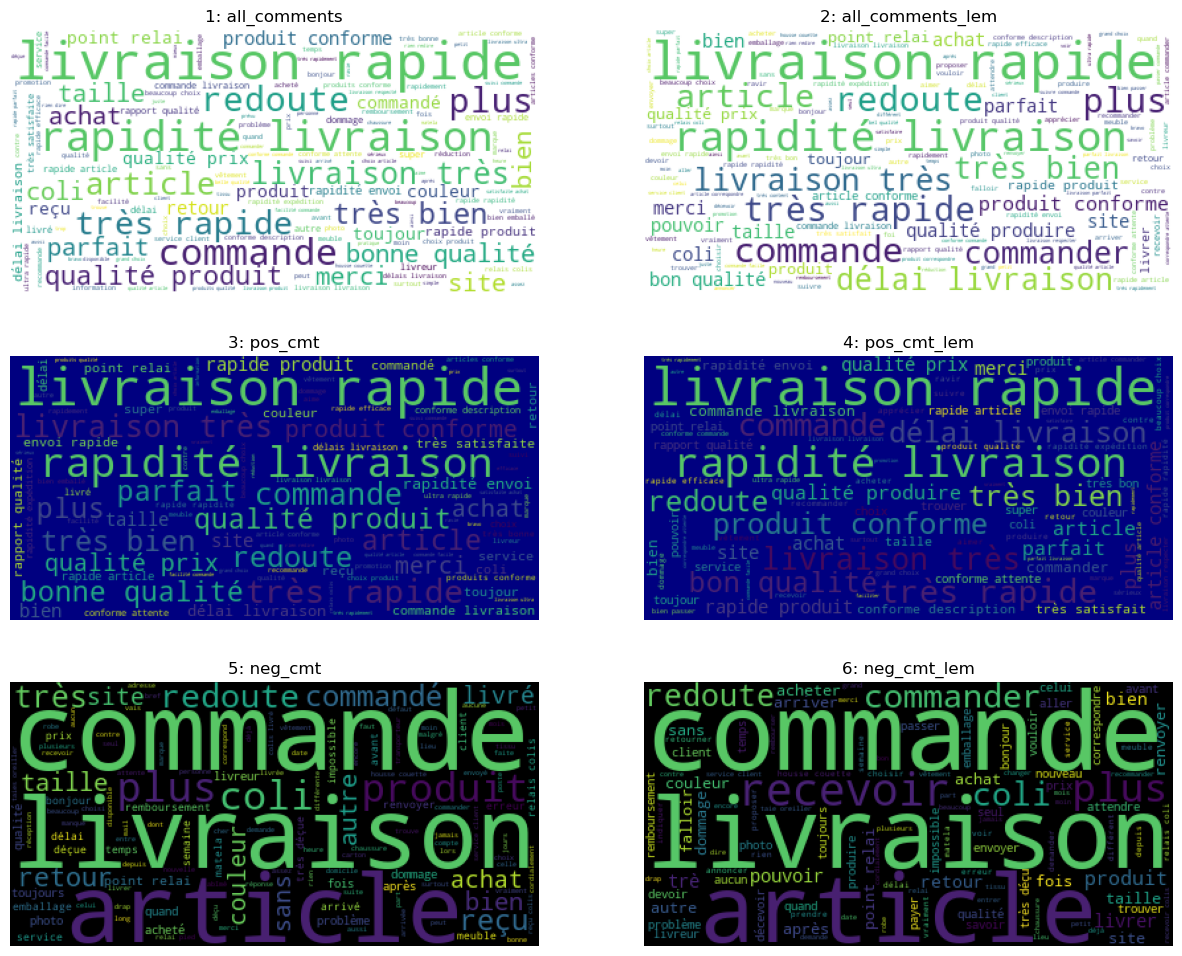

In [18]:
fig = plt.figure(figsize = (15, 12))
j = 1
bcolor = "white"
for cmt, cmt_lem, cmt_title, cmt_lem_title, bcolor in all_cmt_list:
    ax = fig.add_subplot(3,2,j)
    wc = generate_word_cloud(cmt, background_color = bcolor)
    ax.imshow(wc)
    plt.title(str(j) + ": " + cmt_title)
    ax.axis('off')

    ax = fig.add_subplot(3,2,j+1)
    wc = generate_word_cloud(cmt_lem, background_color = bcolor)
    ax.imshow(wc)
    plt.title(str(j+1) + ": " + cmt_lem_title)
    ax.axis('off')
    j = j+2

####  Wordcloud of comment_stem versus comment_lemmatized 

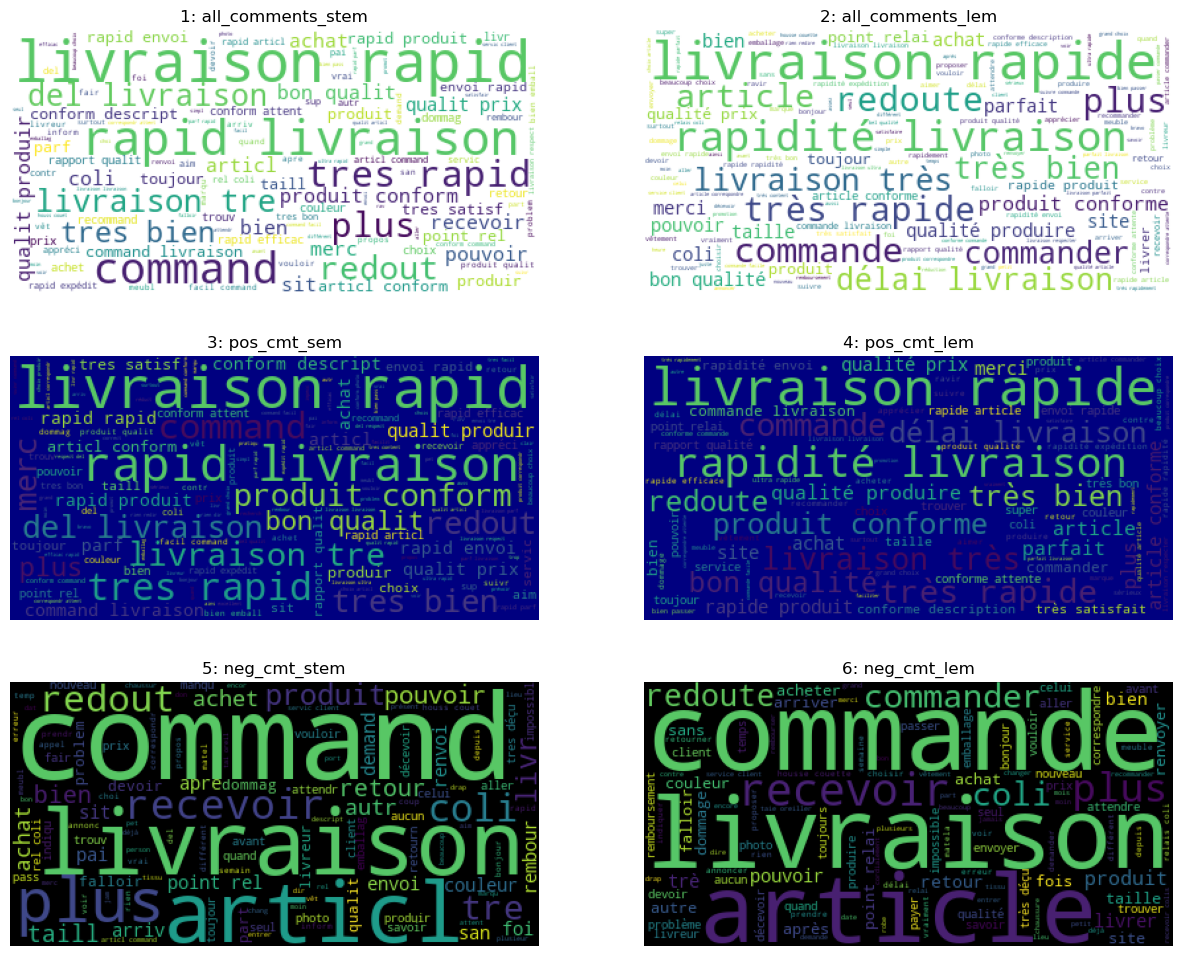

In [19]:
fig = plt.figure(figsize = (15, 12))
j = 1
bcolor = "white"
for cmt, cmt_lem, cmt_title, cmt_lem_title, bcolor in stem_vs_lem:
    ax = fig.add_subplot(3,2,j)
    wc = generate_word_cloud(cmt, background_color = bcolor)
    ax.imshow(wc)
    plt.title(str(j) + ": " + cmt_title)
    ax.axis('off')

    ax = fig.add_subplot(3,2,j+1)
    wc = generate_word_cloud(cmt_lem, background_color = bcolor)
    ax.imshow(wc)
    plt.title(str(j+1) + ": " + cmt_lem_title)
    ax.axis('off')
    j = j+2

###  Word distribution in the overall comments

In [20]:
# Further cleaning needed 
z = df["comment_stem"]
df["stem_len"] = df["comment_stem"].apply(lambda x: len(x))
df[(z=="rieb") | (z=="xxx" )| (z=="tuot") |(df["stem_len"]<=2)]

comment  rating comment_cleaned comment_lemmatized  \
2760   vous avez tout fait       5                                      
2950         Tout a été ok       5                                      
3047          \n.?\n\n?...       5                                      
3107                 tout        5                                      
3111                 Tout        5                                      
...                    ...     ...             ...                ...   
22123                    👍       5                                      
22124                    X       5                                      
22125                    -       4                                      
22126                            4                                      
22127                    👍       4                                      

      comment_stem  stem_len  
2760                       0  
2950                       0  
3047                       0  
3107                       0  
3111                       0  
...            ...       ...  
22123                      0  
22124                      0  
22125                      0  
22126                      0  
22127                      0  

[293 rows x 6 columns]

In [21]:
# Removes lines with comments_stem empty or too small e.g length <= 4
z = df["stem_len"]
print ("number of comment_stem wwith lenght <= 4: ", len(df[z<=4]))
# after analysis we have "rieb", "xxx", "tuot" in comment_stem to remove

number of comment_stem wwith lenght <= 4:  786


In [22]:
z = df["comment_stem"]
index_to_drop = df[(z=="rieb") | (z=="xxx" )| (z=="tuot") |(df["stem_len"]<=4)].index

df.drop(index_to_drop, inplace = True) 

print ("number of comment_stem with lenght <= 4: ", len(df[df["stem_len"]<=4]))


number of comment_stem with lenght <= 4:  0


In [23]:
# word frequency distribution
all_tokens = word_tokenize(all_comments_lem, language='french')
pos_tokens = word_tokenize(pos_cmt_lem, language='french')
neg_tokens = word_tokenize(neg_cmt_lem, language='french')

fd_all = nltk.FreqDist(all_tokens)
fd_pos = nltk.FreqDist(pos_tokens)
fd_neg = nltk.FreqDist(neg_tokens)

#### Saved processed comment to a cvs file to be used for topic modeling

In [24]:
df.to_csv("comment_cleaned.csv")

#### Top 20 most frequent words

In [25]:
print("top ten for all comments:")
print("------------------------")
print(fd_all.most_common(10))
print("------------------------")
print("top ten for positive comments:")
print(fd_pos.most_common(10))
print("------------------------")
print("top ten for negative comments:")
print(fd_neg.most_common(10))

top ten for all comments:
------------------------
[('livraison', 9411), ('rapide', 5802), ('très', 5370), ('commande', 4275), ('rapidité', 4021), ('qualité', 3725), ('article', 3516), ('produit', 3063), ('bien', 2537), ('conforme', 2347)]
------------------------
top ten for positive comments:
[('livraison', 8581), ('rapide', 5747), ('très', 4838), ('rapidité', 3995), ('commande', 3489), ('qualité', 3421), ('article', 2920), ('produit', 2734), ('conforme', 2269), ('bien', 2263)]
------------------------
top ten for negative comments:
[('livraison', 830), ('commande', 786), ('colis', 665), ('article', 596), ('recevoir', 577), ('plus', 550), ('commander', 534), ('très', 532), ('livrer', 364), ('redoute', 342)]


In [26]:
dfd_all = pd.DataFrame(fd_all.most_common(), columns=["token", "frequency"])
dfd_neg = pd.DataFrame(fd_neg.most_common(), columns=["token", "frequency"])
dfd_pos= pd.DataFrame(fd_pos.most_common(), columns=["token", "frequency"])
dfd_neg.head(10)

token  frequency
0  livraison        830
1   commande        786
2      colis        665
3    article        596
4   recevoir        577
5       plus        550
6  commander        534
7       très        532
8     livrer        364
9    redoute        342

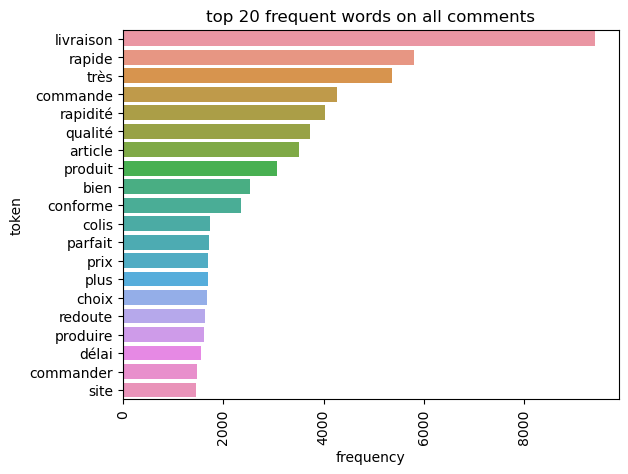

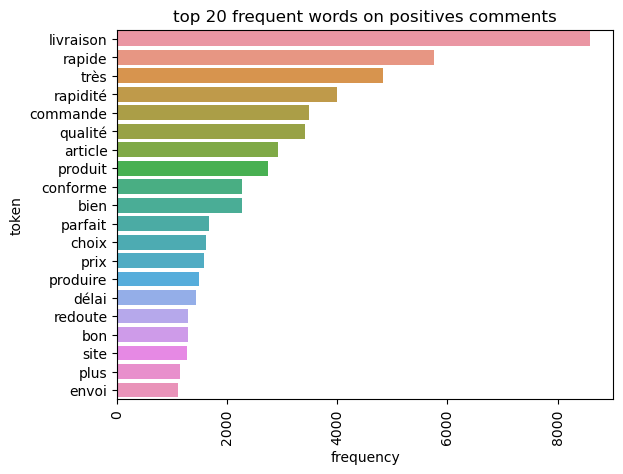

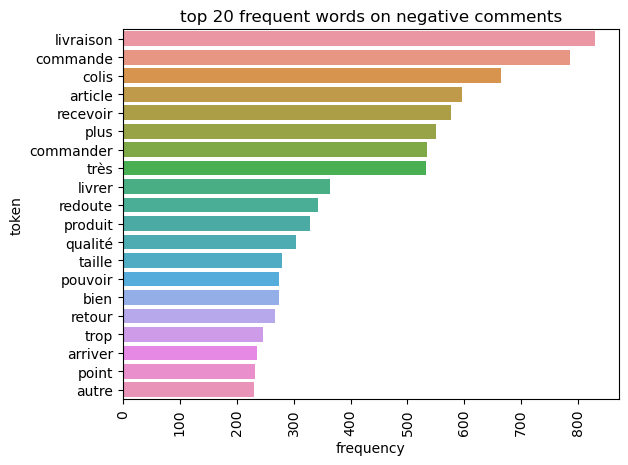

In [27]:
sns.barplot(data=dfd_all.head(20), y="token", x="frequency")
plt.title("top 20 frequent words on all comments")
plt.xticks(rotation=90)
plt.show()

sns.barplot(data=dfd_pos.head(20), y="token", x="frequency")
plt.title("top 20 frequent words on positives comments")
plt.xticks(rotation=90)
plt.show()

sns.barplot(data=dfd_neg.head(20), y="token", x="frequency")
plt.title("top 20 frequent words on negative comments")
plt.xticks(rotation=90)
plt.show()

In [28]:
# Number of token for all comments
len(dfd_all)

7528

In [35]:
df.head()

comment  rating  \
0  Facilte, sollicitations dosées...qualité..on p...       4   
1  Livraison impeccable avec possibilité de prend...       4   
2  Achat d'un canapé La Redoute intérieurs le 6/9...       4   
3  je commande depuis longtemps chez la redoute; ...       4   
4  Comme d'habitude, aucun souci et rapidité d'ex...       5   

                                     comment_cleaned  \
0  facilte sollicitations dosées qualité pourrait...   
1  livraison impeccable possibilité prendre samed...   
2  achat canapé redoute intérieurs site redoute a...   
3  commande depuis longtemps redoute appréciais c...   
4  habitude aucun souci rapidité expédition colis...   

                                  comment_lemmatized  \
0  facilte sollicitation doser qualité pouvoir ce...   
1  livraison impeccable possibilité prendre samed...   
2  achat canapé redoute intérieur site redoute ab...   
3  commande depuis longtemps redoute appréciai ch...   
4  habitude aucun souci rapidité expédition colis...   

                                        comment_stem  stem_len  
0  facilt sollicit dos qualit pouvoir cepend amél...       558  
1  livraison impecc possibil prendr samed matin b...       461  
2  achat canap redout intérieur sit redout abord ...       426  
3  command depuis longtemp redout appréci choix r...       370  
4  habitud aucun souc rapid expédit colis bravo d...       366

## Topic modeling


In [36]:
# We used comment_cleaned for topic modeling
X = df["comment_cleaned"]

# we split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify = y)


### Vectorization  with CountVectorizer

In [38]:
vectorizer = CountVectorizer(max_df=0.9, min_df=25)

# apply transformation
tf_train = vectorizer.fit_transform(X_train).toarray()

# tf_feature_names to see what each word represent in the metrix
tf_feature_names = vectorizer.get_feature_names_out()

In [39]:
#LatentDirichletAnnotation
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)


In [40]:
model.fit(tf_train)

LatentDirichletAllocation(random_state=0)

In [41]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [42]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0          très          1578.0        rapide          4198.1     livraison   
1          rien           555.4     livraison          2946.6         délai   
2      commande           530.2          très          1059.9      commande   
3    satisfaite           530.1       qualité           439.9        délais   
4          bien           506.1       produit           363.9         suivi   
5       parfait           439.4      efficace           317.9      respecté   
6    rapidement           385.0         envoi           303.7          prix   
7         merci           343.1         super           285.1         point   
8      articles           262.5      commande           253.3       produit   
9         achat           208.1       parfait           230.4          très   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  \
0          1136.4      produits          1130.0         envoi           497.0   
1           585.1       qualité          1052.9          très           318.5   
2           477.2          prix           975.8       qualité           242.9   
3           471.1         choix           949.8       couleur           238.1   
4           250.8       redoute           720.1        housse           236.0   
5           199.1      articles           493.3       couette           219.8   
6           197.1      toujours           472.9         achat           172.9   
7           185.2          très           447.8         draps           127.7   
8           180.5       rapport           348.5    traitement           109.6   
9           178.1      beaucoup           313.7         tissu           105.9   

  Topic 5 words Topic 5 weights Topic 6 words Topic 6 weights Topic 7 words  \
0      conforme          1082.8      rapidité          2979.7          plus   
1       produit          1037.7     livraison          1742.2        taille   
2   description           589.0       qualité           456.2      commande   
3       article           479.2      commande           374.2       redoute   
4     conformes           475.9    expédition           343.9          trop   
5      attentes           388.1          date           218.8          reçu   
6      produits           329.4      produits           207.7      commandé   
7    correspond           310.5       produit           195.2          fois   
8     livraison           266.6    efficacité           182.9       article   
9       qualité           239.6       service           181.0      toujours   

  Topic 7 weights Topic 8 words Topic 8 weights Topic 9 words Topic 9 weights  
0           676.4          site           679.3         colis          1264.4  
1           475.7      commande           663.1          bien           767.6  
2           443.7        facile           594.1        relais           570.7  
3           429.0        retour           573.0         livré           413.1  
4           399.0      facilité           488.2     livraison           373.4  
5           319.6        simple           265.1          très           322.5  
6           315.4          sans           244.1          plus           296.4  
7           303.6      problème           213.6         point           295.8  
8           237.3     livraison           212.1        arrivé           242.0  
9           193.4      articles           203.4         temps           239.4

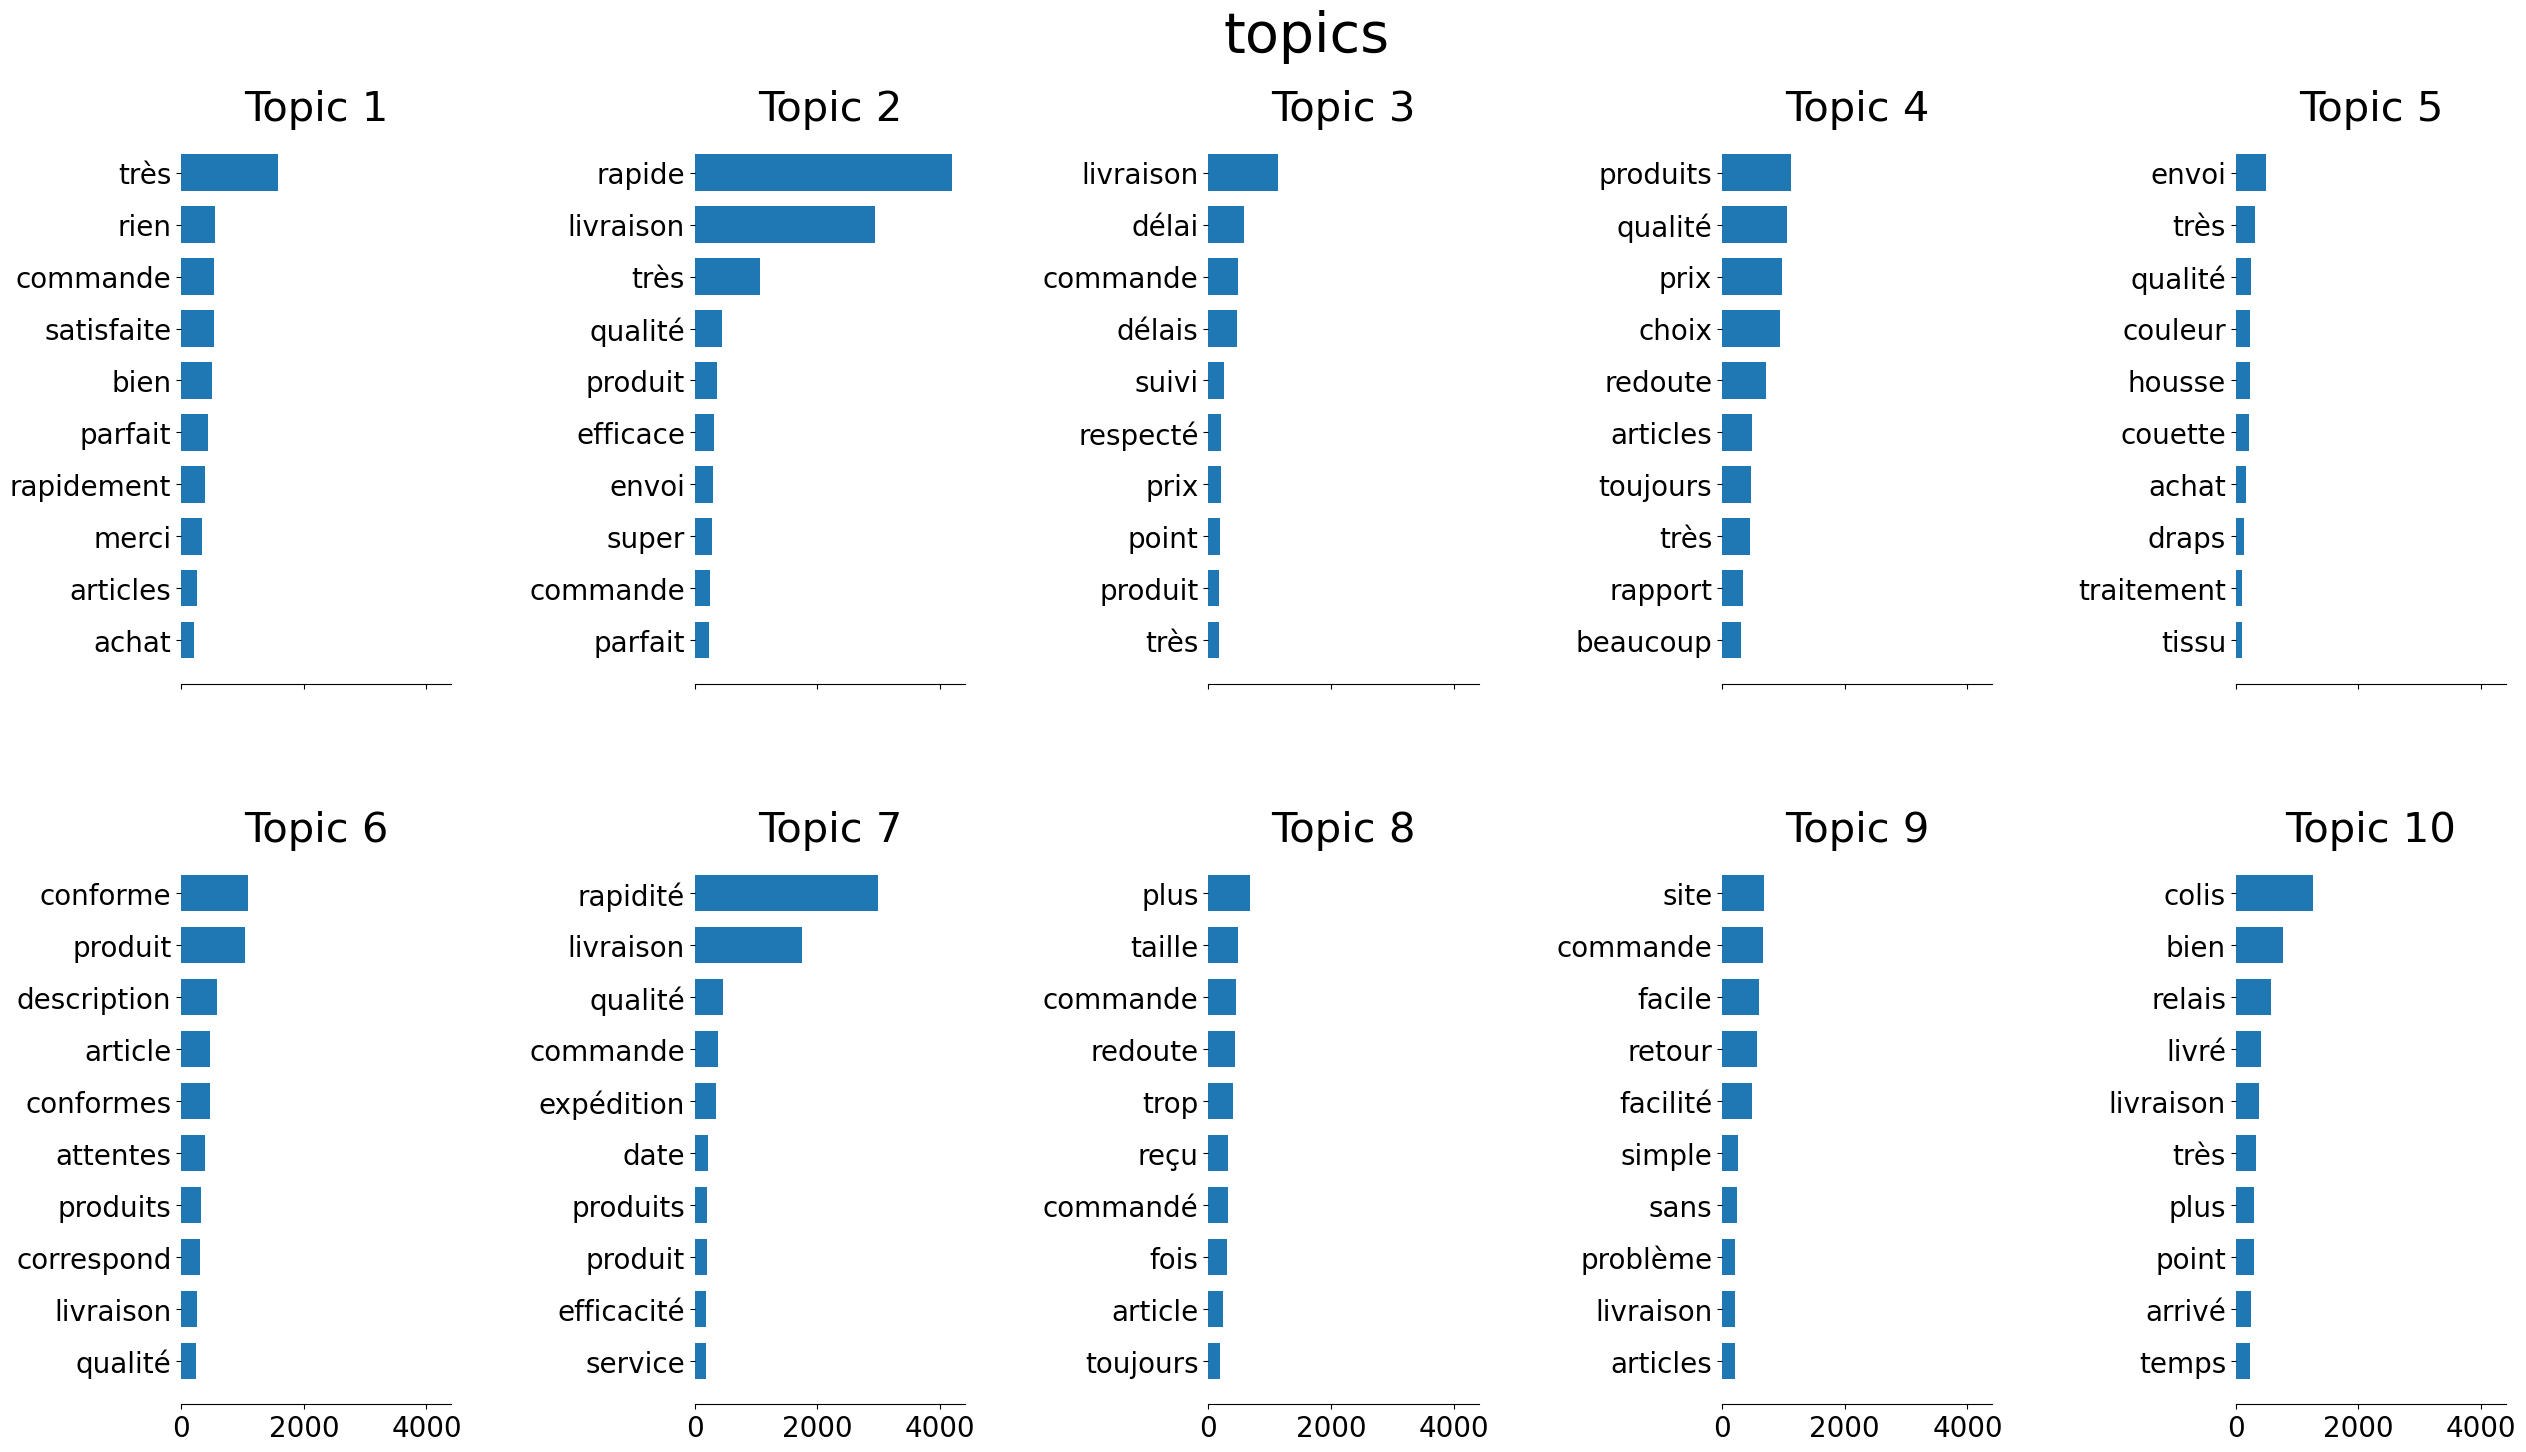

In [63]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

no_top_words = 10
plot_top_words(model, tf_feature_names, no_top_words, "topics")

In [67]:
# we remove those words from comment_cleaned
def remove_sw(text, words_to_remove):
    tokens = word_tokenize(text, language='french')
    tokens_without_sw = [t for t in tokens if t not in words_to_remove]
    return " ".join(tokens_without_sw)

In [125]:
words_to_remove = ["bien", "très", "tres", "rien", "merci", "satisfaite", "parfait", "merci", "super", 
               "beaucoup", "plus", "trop", "fois", "toujours", "facile", "sans", "simple", "autre", 
                  "bonne", "avant", "vraiment", "aucune", "après" ,"déja", "elle", "celle", "chaque", 
                   "tous", "faut", "moins", "lors", "aller", "vais"]

In [126]:
df["comment_topics"] = df["comment_cleaned"].apply(lambda x: remove_sw(x, words_to_remove))
df.head(2)

comment  rating  \
0  Facilte, sollicitations dosées...qualité..on p...       4   
1  Livraison impeccable avec possibilité de prend...       4   

                                     comment_cleaned  \
0  facilte sollicitations dosées qualité pourrait...   
1  livraison impeccable possibilité prendre samed...   

                                  comment_lemmatized  \
0  facilte sollicitation doser qualité pouvoir ce...   
1  livraison impeccable possibilité prendre samed...   

                                        comment_stem  stem_len  \
0  facilt sollicit dos qualit pouvoir cepend amél...       558   
1  livraison impecc possibil prendr samed matin b...       461   

                                     comments_topics  \
0  facilte sollicitations dosées qualité pourrait...   
1  livraison impeccable possibilité prendre samed...   

                                      comment_topics  cmt_length  
0  facilte sollicitations dosées qualité pourrait...         642  
1  livraison impeccable possibilité prendre samed...         494

In [127]:
df[df["rating"]<=3]["comment_topics"]

3157     aucun respect dates livraison commandes ampm r...
3158     incapable annuler commande incapable proposer ...
3159     commande suite promotion article frais envoi o...
3160     août passé commande composée housses couette t...
3161     retours articles compliqué marchait code papie...
                               ...                        
23462                                                 dure
23463                                             rapidité
23464                                              produit
23465                                             horrible
23466                                            livraison
Name: comment_topics, Length: 2690, dtype: object

In [128]:
df["cmt_length"] = df["comment_topics"].apply(lambda x: len(x))

In [129]:
df = df[df["cmt_length"] >=2]

In [130]:
# Vectorization on the new variable comments_topics this time

# We used comment_cleaned for topic modeling
X = df[df["rating"]<=3]["comment_topics"]

# vectorization
vectorizer = CountVectorizer(max_df=0.9, min_df=25)

# fit_transform 
tf = vectorizer.fit_transform(X).toarray()

# tf_feature_names to see what each word represent in the metrix
tf_feature_names = vectorizer.get_feature_names_out()

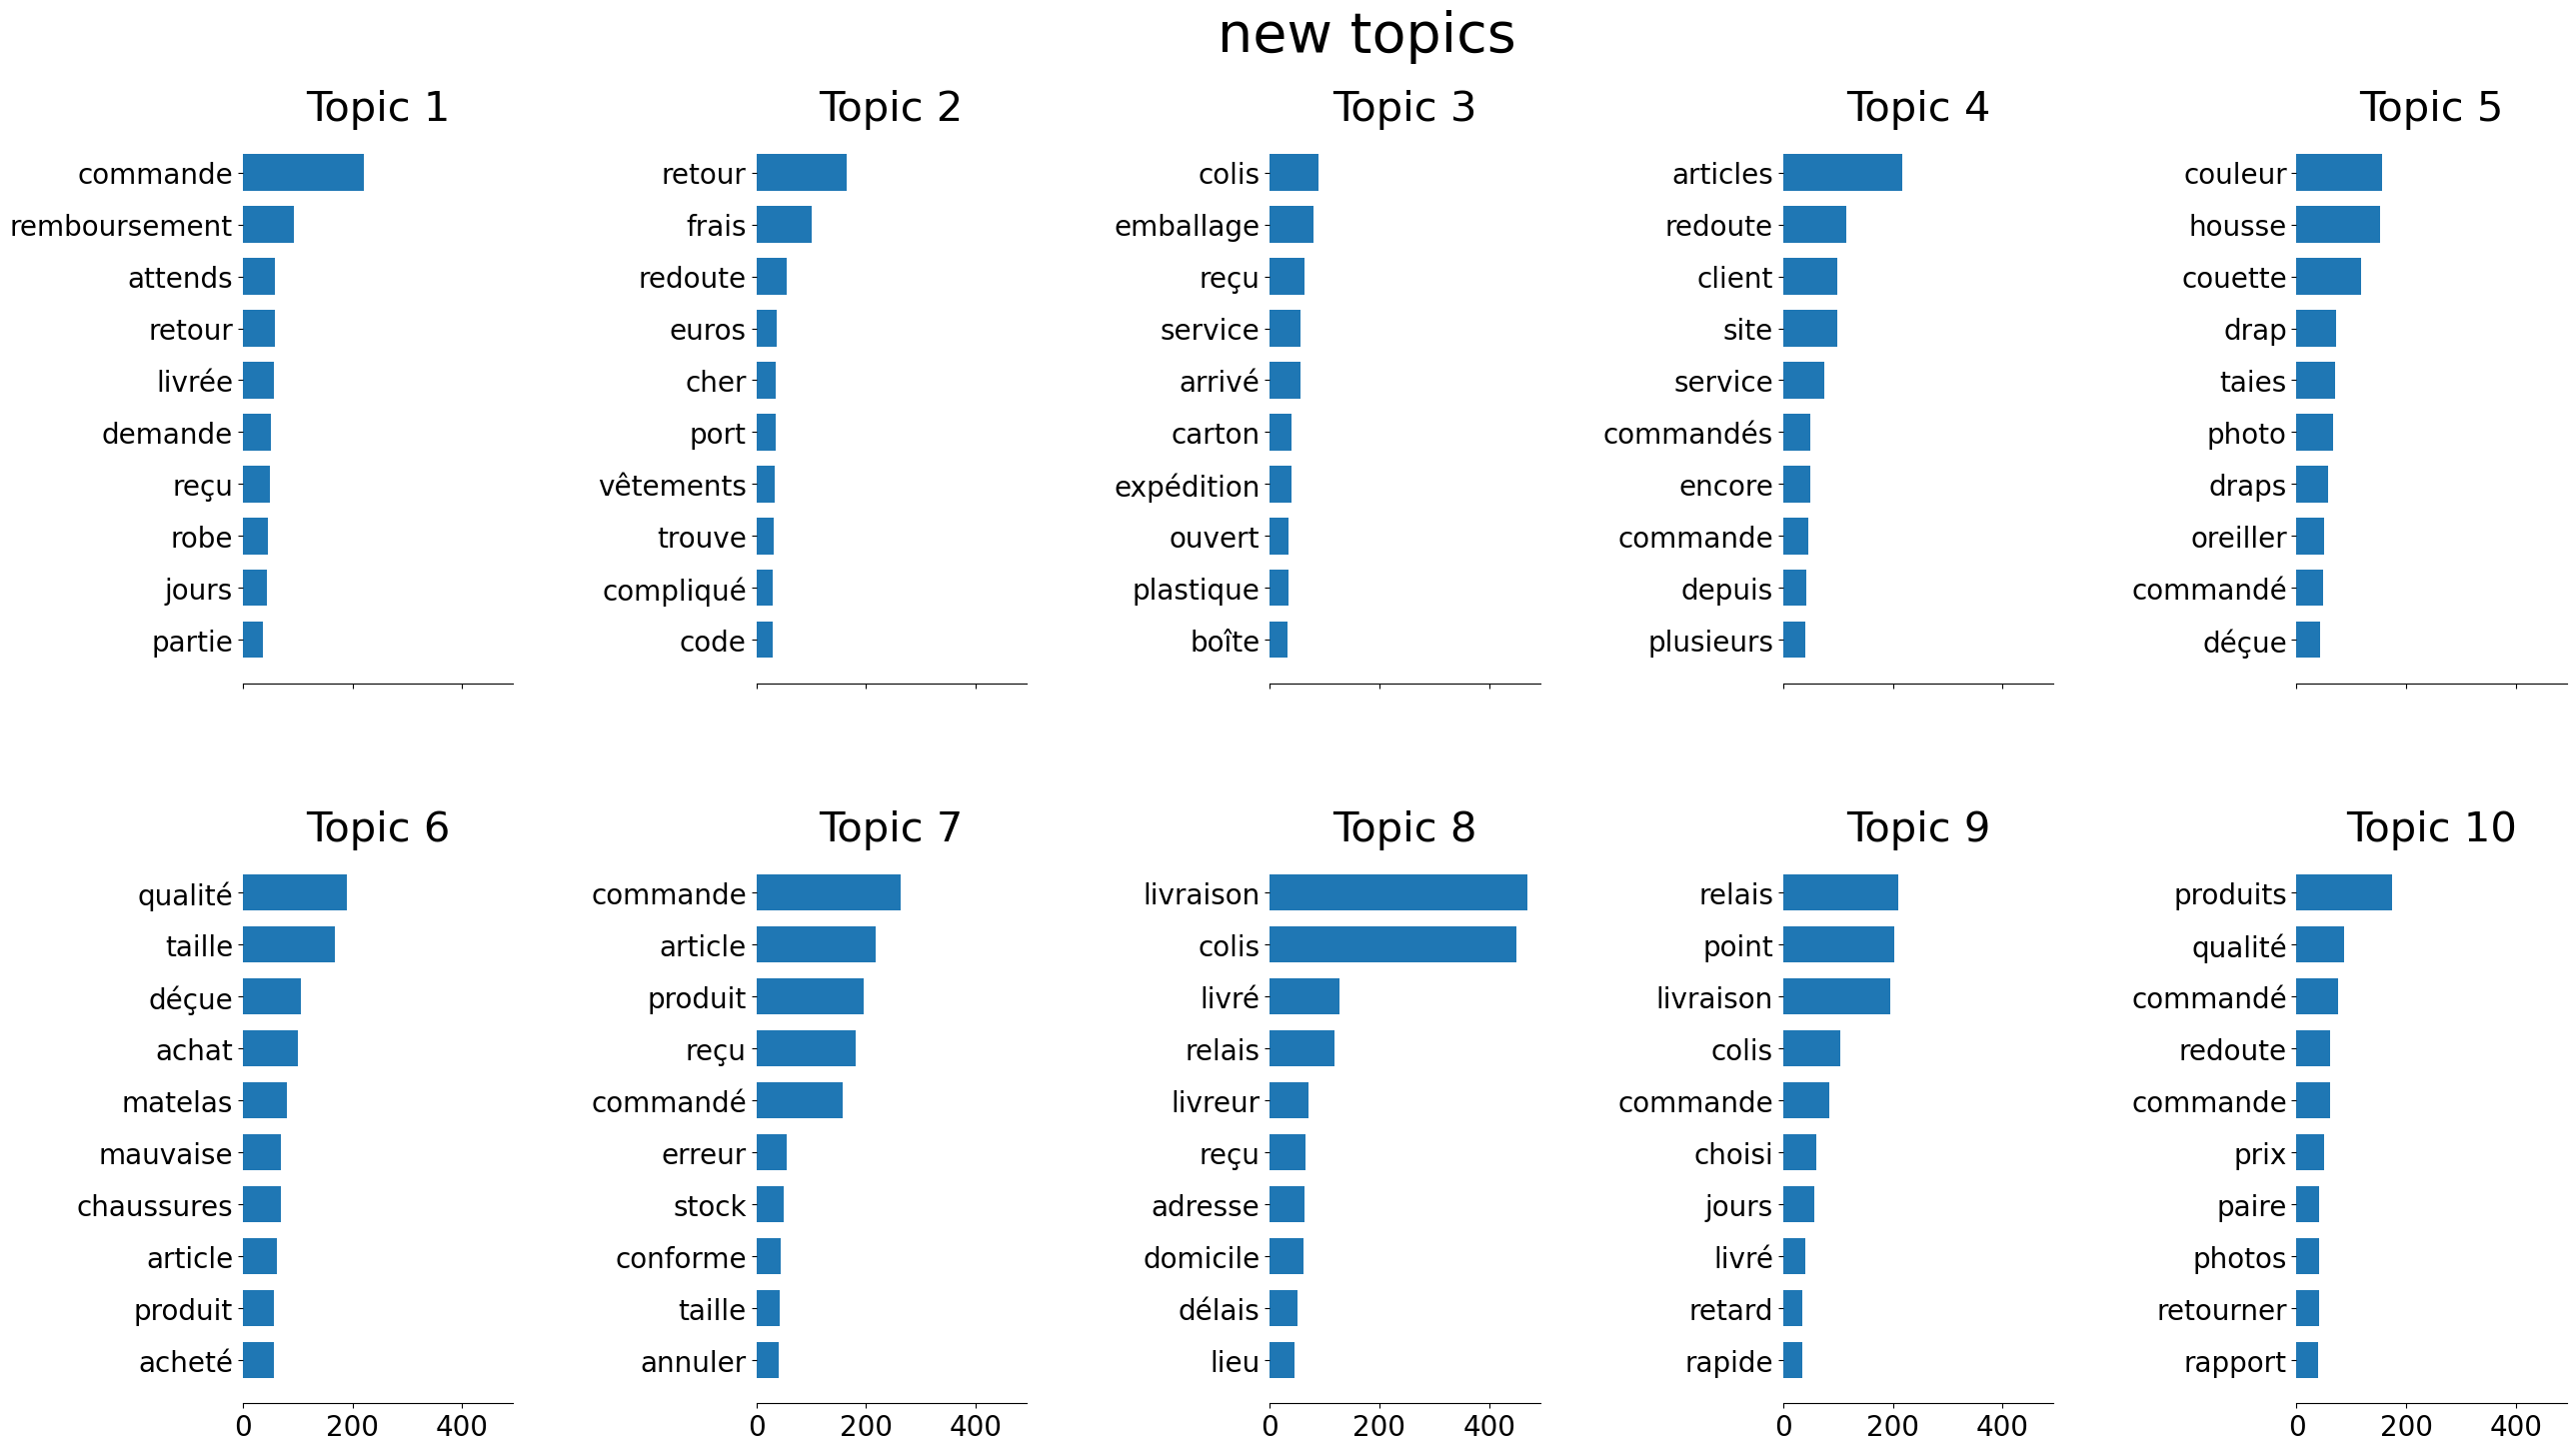

In [131]:

#model
number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit
model.fit(tf)

# display topics
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

# plot topics
no_top_words = 10
plot_top_words(model, tf_feature_names, no_top_words, "new topics")


In [132]:
X.shape

(2690,)

Extracting tf-idf features for NMF...
done in 0.091s.
done in 0.809s.


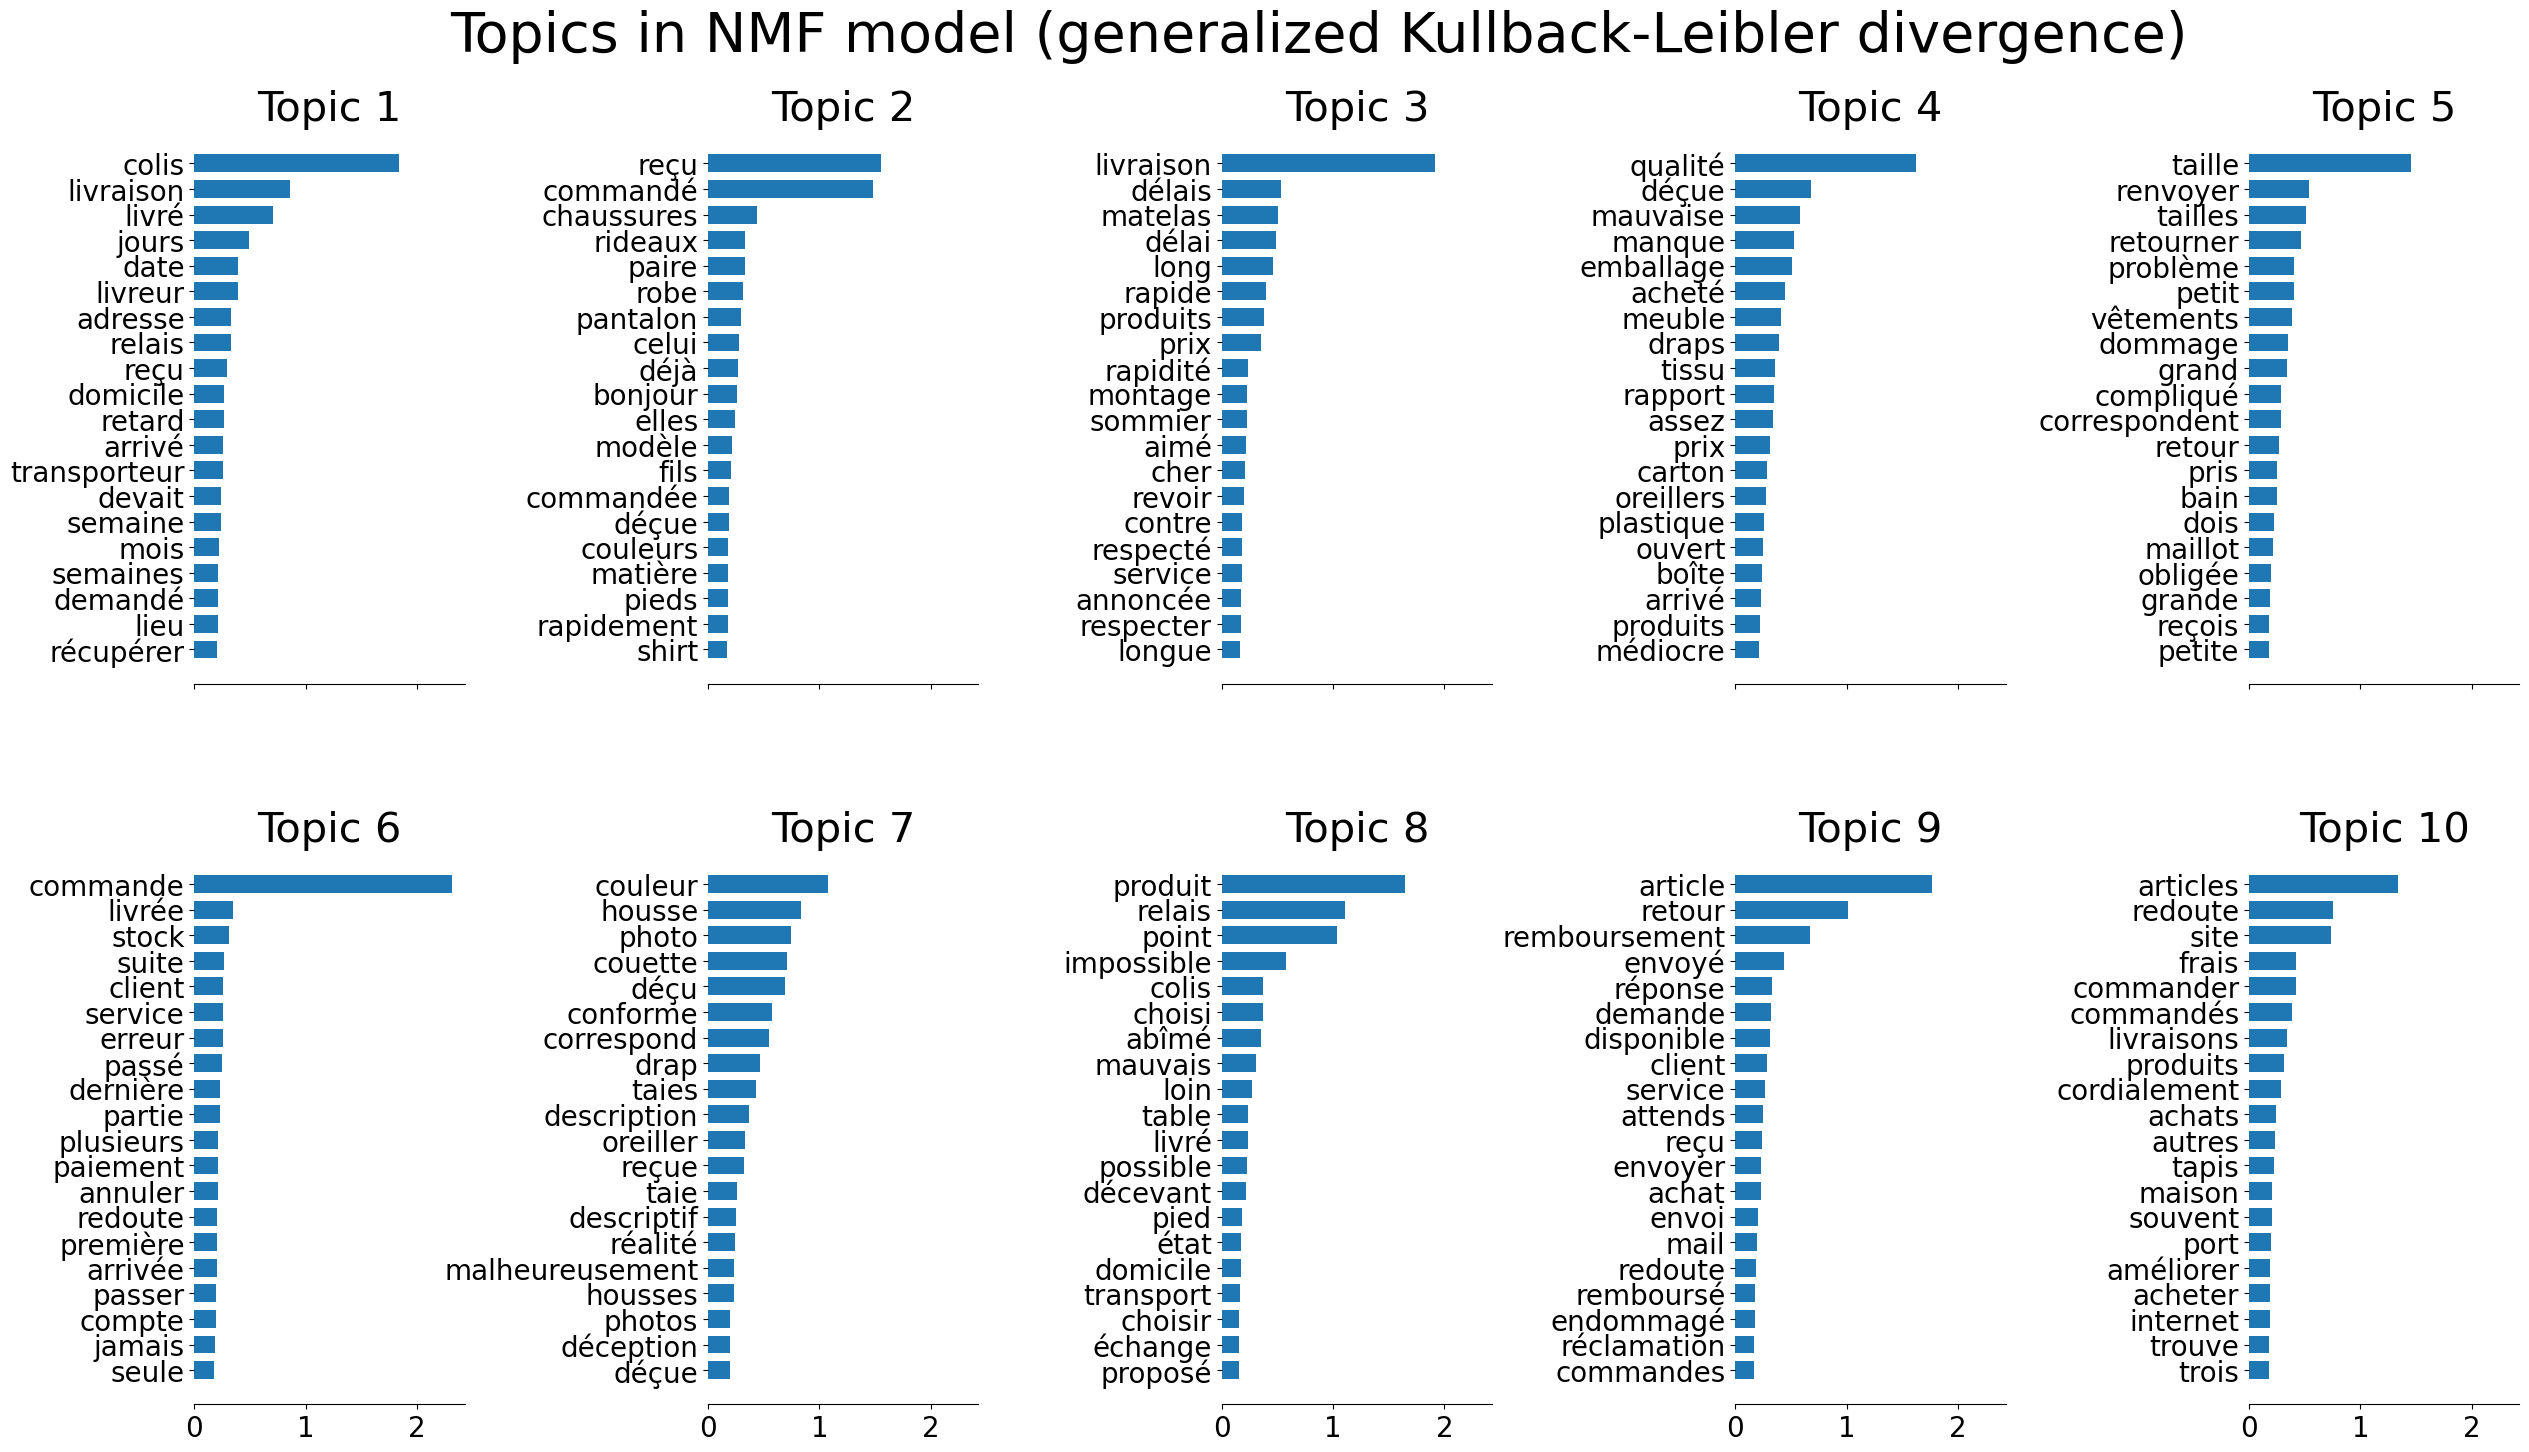

In [133]:
# Use tf-idf features for NMF.
from sklearn.decomposition import NMF

#n_samples = 2690
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

#from time import time

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(X)
print("done in %0.3fs." % (time() - t0))

#applying NMF
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)

### Preprocessing with CountVectorizer
- CountVectorizer
- RandomUnderSampling

### T

In [134]:
# Vectorization on the new variable comments_topics this time

# We used comment_cleaned for topic modeling
X = df["comment_topics"]

# vectorization
vectorizer = CountVectorizer(max_df=0.9, min_df=25)

# fit_transform 
tf = vectorizer.fit_transform(X).toarray()

# tf_feature_names to see what each word represent in the metrix
tf_feature_names = vectorizer.get_feature_names_out()

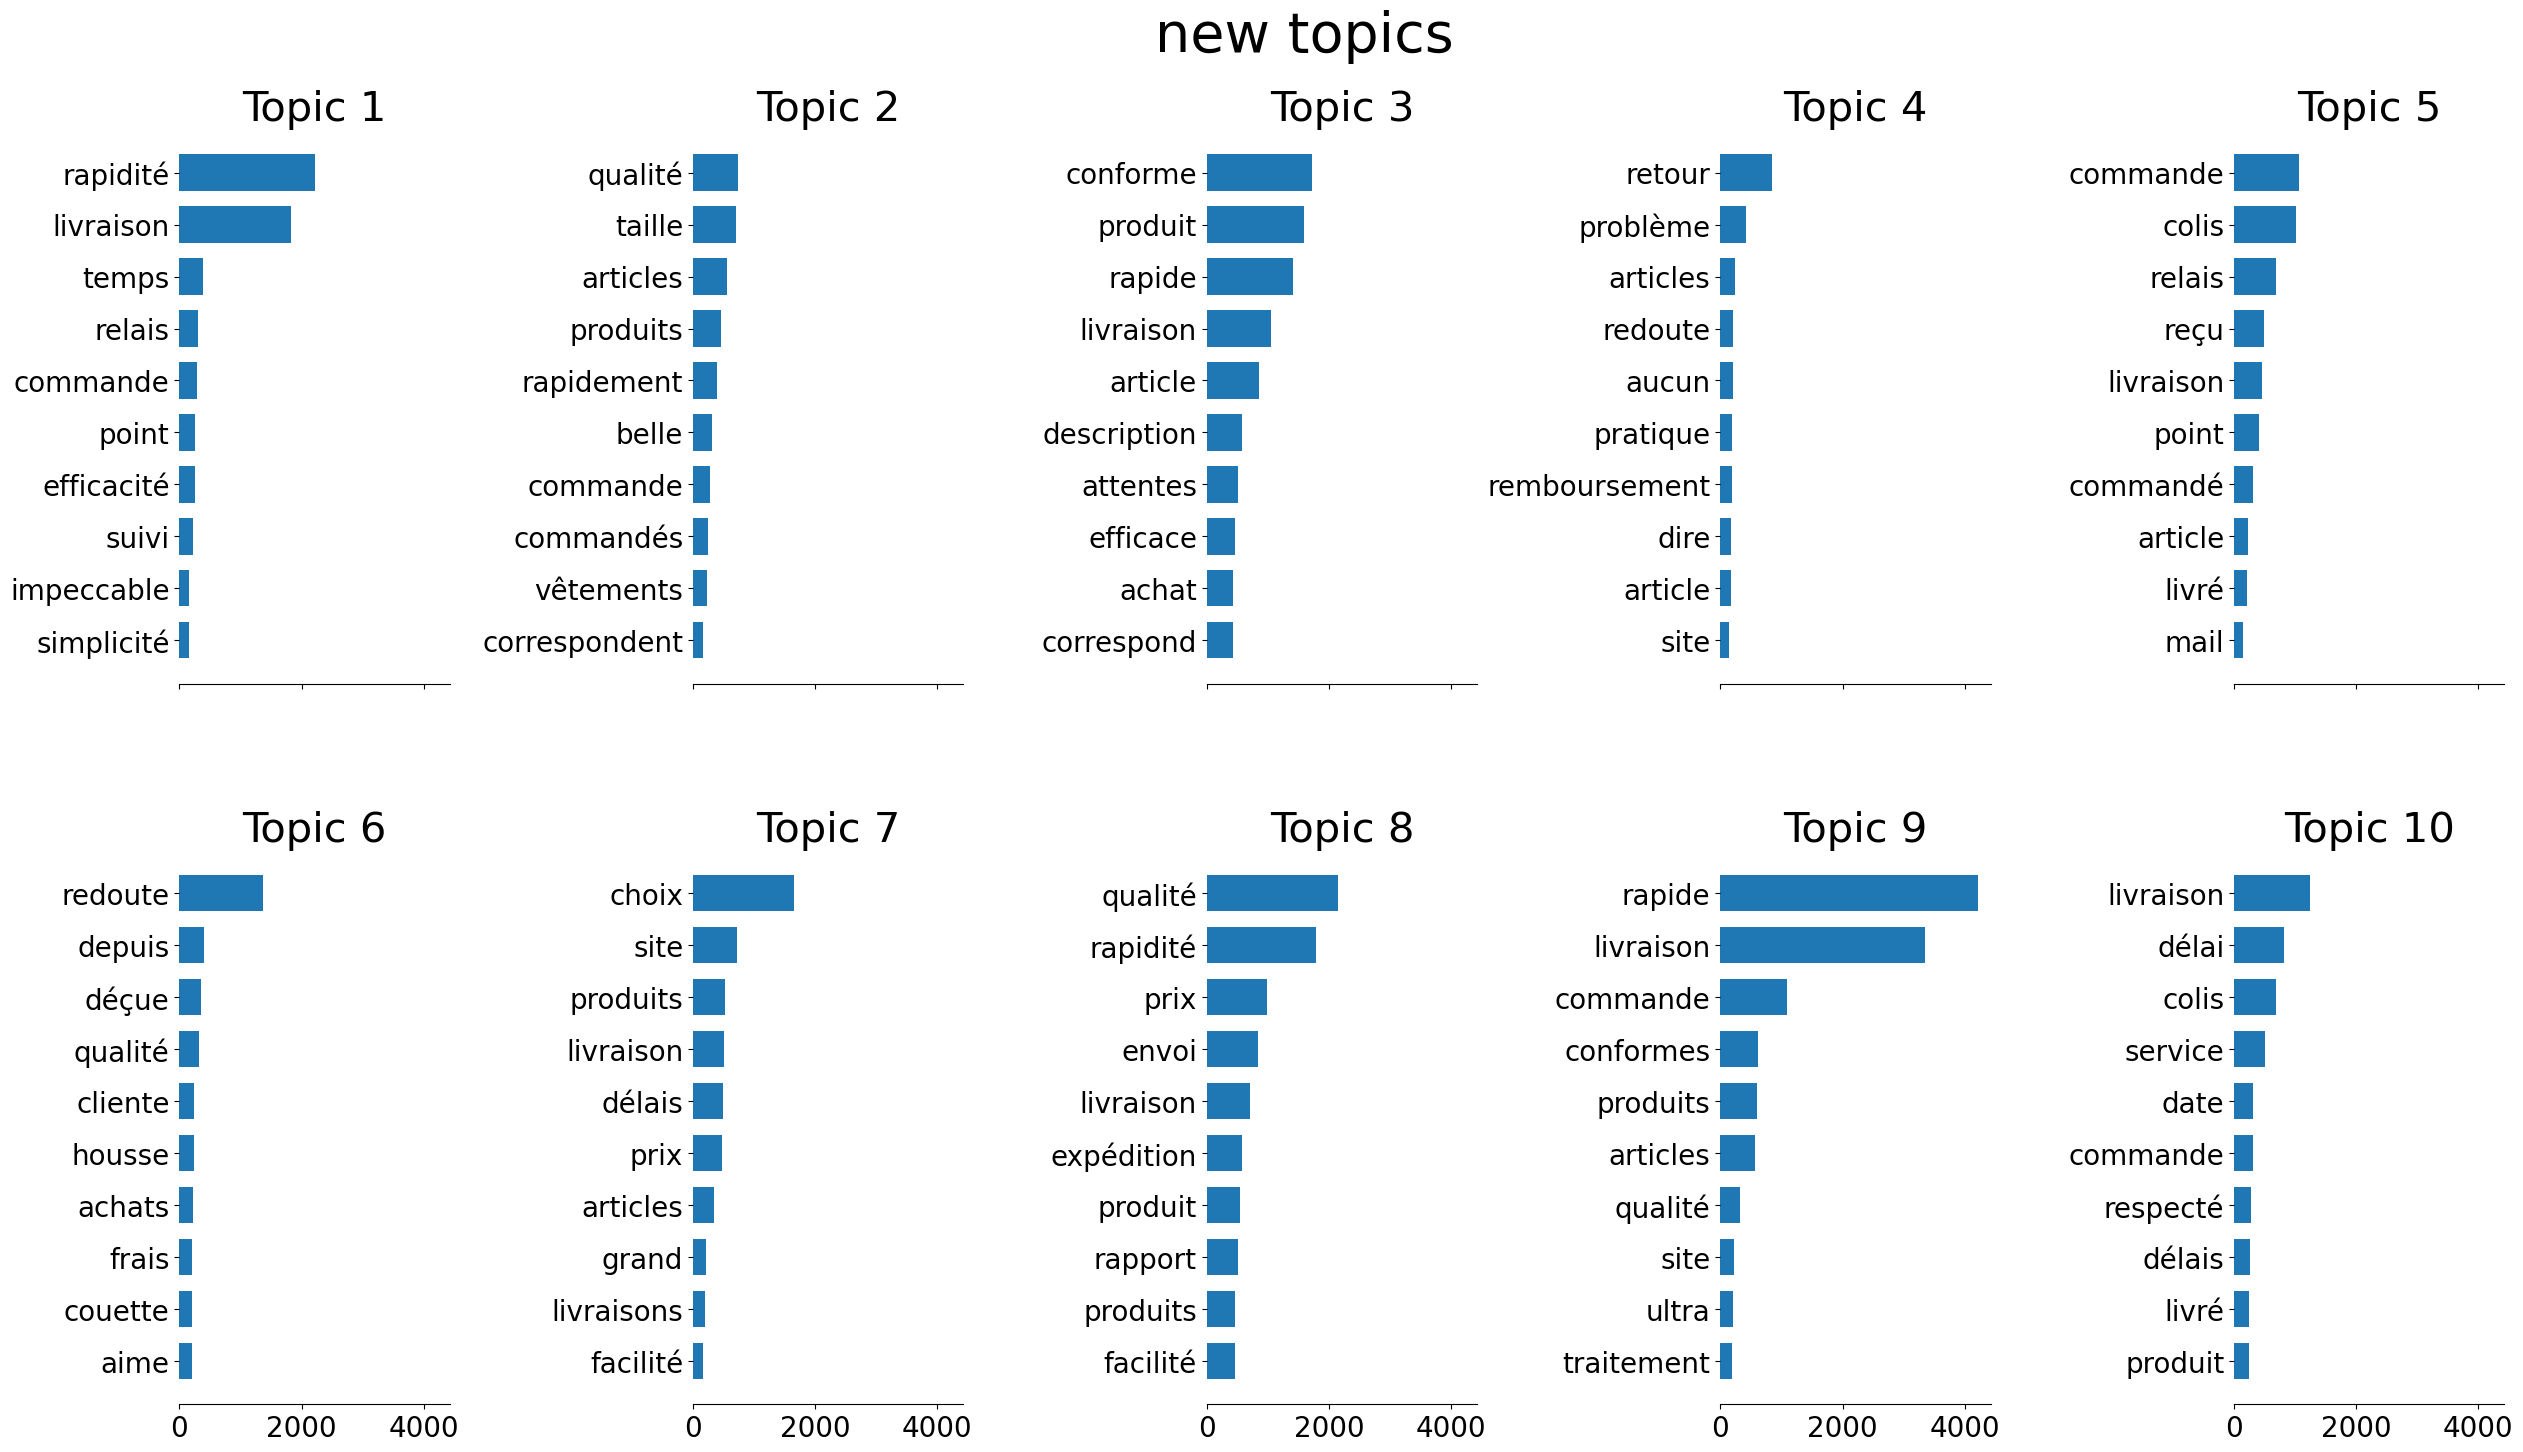

In [135]:

#model
number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

#fit
model.fit(tf)

# display topics
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

# plot topics
no_top_words = 10
plot_top_words(model, tf_feature_names, no_top_words, "new topics")


In [136]:
X.shape

(22462,)

Extracting tf-idf features for NMF...
done in 0.211s.
done in 2.348s.


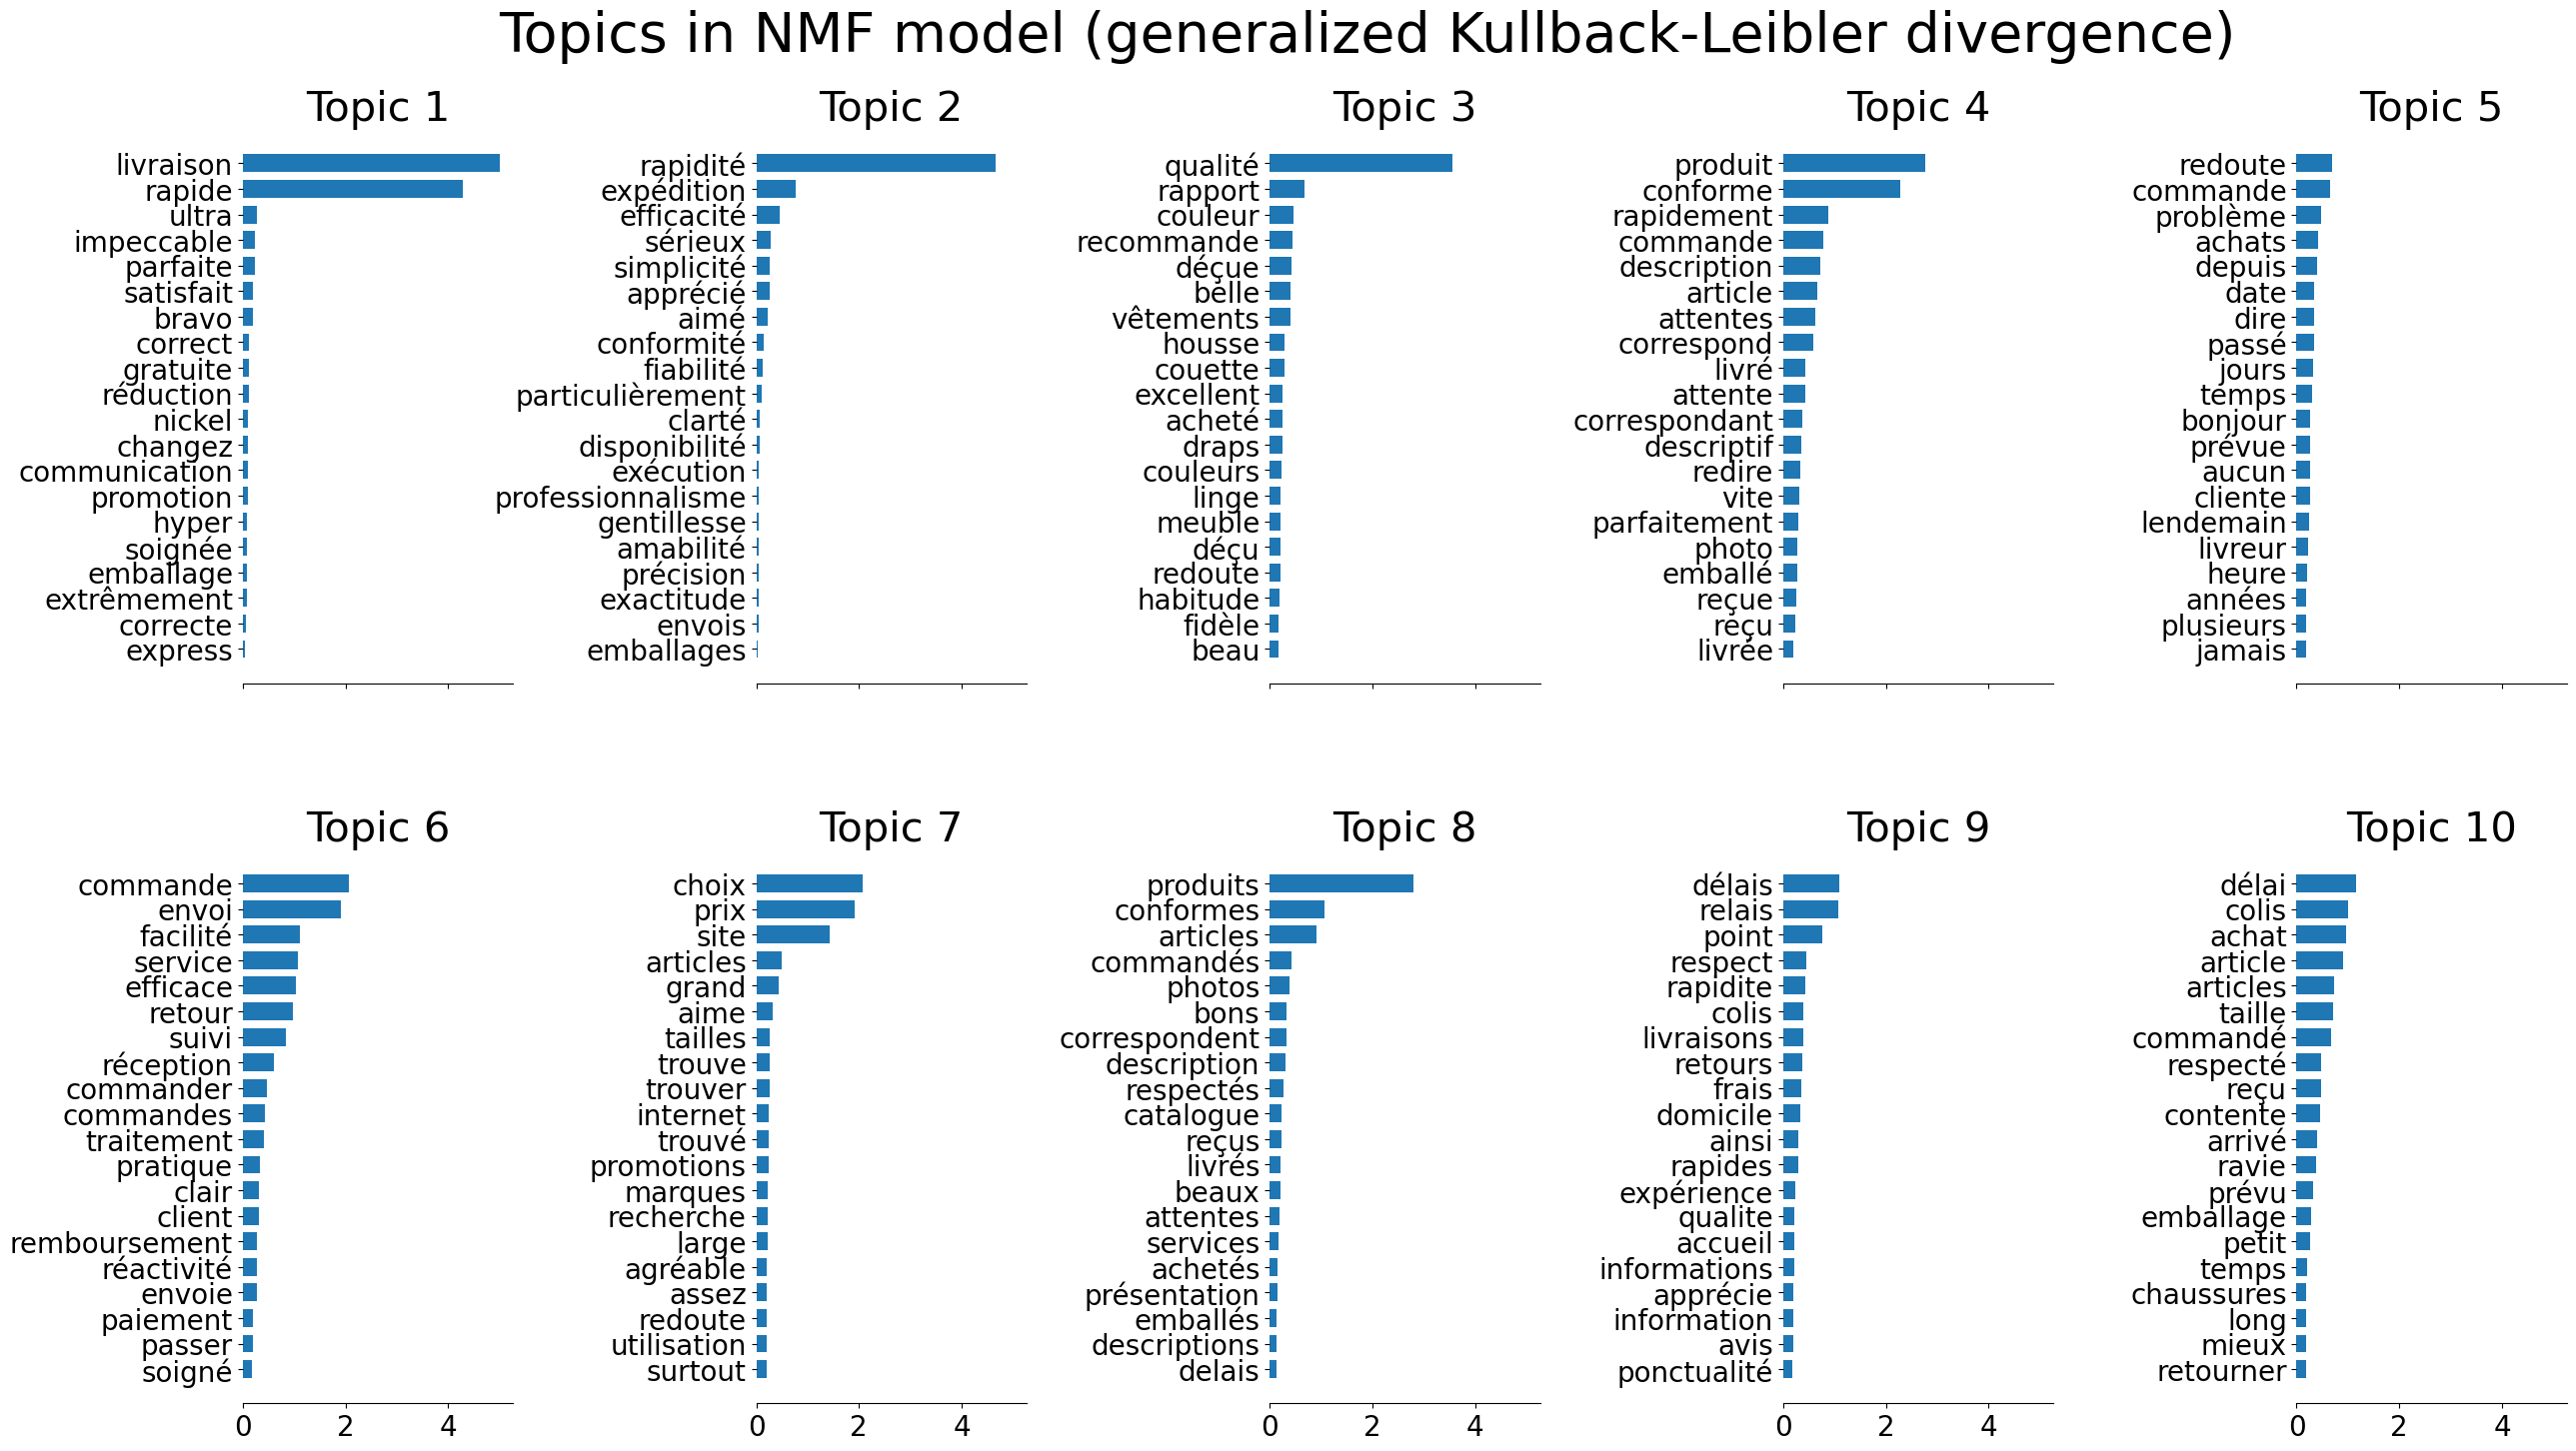

In [137]:
# Use tf-idf features for NMF.
from sklearn.decomposition import NMF

#n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20
batch_size = 128
init = "nndsvda"

#from time import time

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.95, min_df=2, max_features=n_features, stop_words="english"
)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(X)
print("done in %0.3fs." % (time() - t0))

#applying NMF
nmf = NMF(
    n_components=n_components,
    random_state=1,
    init=init,
    beta_loss="kullback-leibler",
    solver="mu",
    max_iter=1000,
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.5,
).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
plot_top_words(
    nmf,
    tfidf_feature_names,
    n_top_words,
    "Topics in NMF model (generalized Kullback-Leibler divergence)",
)